# Training report

This notebook will go over the results after training

## 1. Imports

In [109]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from utils.plotting_utils import plot_metrics, plot_epoch_signal, plot_layer_signal, parse_log_file

## 2. Data

Visualize the data that the model will train on.

Files already downloaded and verified
Files already downloaded and verified


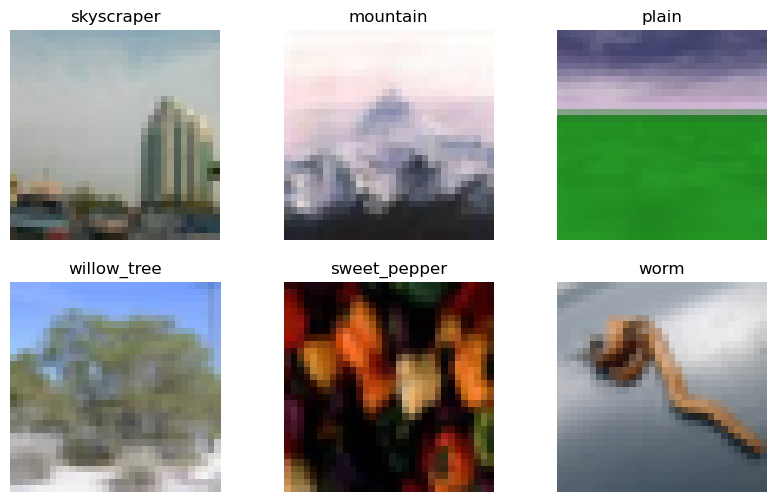

Number of training samples: 50000
Number of testing samples: 10000
Number of classes: 100
Image shape: torch.Size([3, 32, 32])


In [110]:
# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download CIFAR-100 dataset
data_train = datasets.CIFAR100(root="data", train=True, download=True, transform=transform)
data_test = datasets.CIFAR100(root="data", train=False, download=True, transform=transform)

# Function to display images
def show_images(images, labels, class_names, num_images=6):
    plt.figure(figsize=(10, 6))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

# Get some random training images
train_loader = DataLoader(data_train, batch_size=6, shuffle=True)
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Get class names
class_names = data_train.classes

# Show images
show_images(images, labels, class_names)

# Print dataset statistics
print(f"Number of training samples: {len(data_train)}")
print(f"Number of testing samples: {len(data_test)}")
print(f"Number of classes: {len(class_names)}")
print(f"Image shape: {images[0].shape}") 

## 2. Training

Training can be executed using the [run_training.py](./run_training.py) file and will use the default hyper parameters.

Training can be further configured using the config file found in [configs/config_training.json](./configs/config_training.json). This file contains all the main hyperparameters for training.

hyperparameter search can be done using the [run_parameter_search.py](./run_parameter_search.py) file and also has a corresponding config file: [config_parameter_search.json](./configs/config_parameter_search.json).

Once you have configured the config file you can run the following commands to commence training:

In [111]:
# !python run_training.py
# !python run_parameter_search.py

## 3. Results

### 3.1. Testing

TODO: add a run_testing.py script to root so you can do testing, low priority

In [112]:
# TODO: add a run_testing.py script to root so you can do testing, low priority

### 3.2. Metrics

During training data will be logged continuously to both WandB and the local checkpoints folder. Here, data is located under the name of the model and then a unique timestamp and a user description for that run.

The following metrics will be stored:
- loss (training and validation)
- accuracy
- balanced accuracy
- precision
- recall
- f1
- roc_auc
- layer mean, max mean, stdev, and max stdev for the activations (local only)
- layer mean, max mean, stdev, and max stdev for the weights (local only)

During testing metrics will be stored locally in a test_log.txt file with the following metrics
- test_loss
- accuracy
- balanced accuracy
- precision
- recall
- f1
- roc_auc

The local only layer weight and activation metrics are stored in a dictionary per layer. The following helper function will parse the data so that the values and dictionaries are stored in a pandas dataframe for better data handling.

In [114]:
# Define the paths based on the provided variables
model_name = "efficientnet"
run_folder = "2024-07-06_12-11-20_start NF"
train_log_dir = os.path.join(".", "checkpoints", model_name, run_folder, "training_log.txt")
test_log_dir = os.path.join(".", "checkpoints", model_name, run_folder, "test_log.txt")

# Parse the log files
train_df = parse_log_file(train_log_dir)
test_df = parse_log_file(test_log_dir)

Parsing log file: EfficientNet	checkpoints\EfficientNet\2024-07-06_12-11-20_start NF
Columns: ['epoch', 'train_loss', 'val_loss', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'stem.0', 'stem.1', 'stem.2.sigmoid', 'blocks.0.conv.0.0', 'blocks.0.conv.0.1', 'blocks.0.conv.0.2.sigmoid', 'blocks.0.conv.1.se_avgpool', 'blocks.0.conv.1.se_reduce', 'blocks.0.conv.1.se_act1.sigmoid', 'blocks.0.conv.1.se_expand', 'blocks.0.conv.1.se_act2', 'blocks.0.conv.2.0', 'blocks.0.conv.2.1', 'blocks.1.conv.0.0', 'blocks.1.conv.0.1', 'blocks.1.conv.0.2.sigmoid', 'blocks.1.conv.1.0', 'blocks.1.conv.1.1', 'blocks.1.conv.1.2.sigmoid', 'blocks.1.conv.2.se_avgpool', 'blocks.1.conv.2.se_reduce', 'blocks.1.conv.2.se_act1.sigmoid', 'blocks.1.conv.2.se_expand', 'blocks.1.conv.2.se_act2', 'blocks.1.conv.3.0', 'blocks.1.conv.3.1', 'blocks.2.conv.0.0', 'blocks.2.conv.0.1', 'blocks.2.conv.0.2.sigmoid', 'blocks.2.conv.1.0', 'blocks.2.conv.1.1', 'blocks.2.conv.1.2.sigmoid', 'blocks.2.conv.2.se_

Single values/metrics for the layer weights or activation can be obtained by specifying the layer of choice, then specifying the epoch and metric you want to access.

In [115]:
print(train_df["blocks.0.conv.1.se_act2"][10]["mean_act"], train_df["blocks.0.conv.1.se_act2"][10]["std_act"])
print(train_df["blocks.0.conv.1.se_act2"][10])

0.5093109253086622 0.08121049790819988
{'mean_act': 0.5093109253086622, 'std_act': 0.08121049790819988, 'max_mean_act': 0.6111812, 'max_std_act': 0.12305398, 'mean_weight': 0.0, 'std_weight': 0.0, 'max_mean_weight': 0.0, 'max_std_weight': 0.0}


In [116]:
# split the data frame into two data frames, one for the metrics such as accuracy etc and the other for the layer activations and weights
metrics = ['train_loss','val_loss', 'accuracy','balanced_accuracy','precision','recall','f1','roc_auc']
train_metrics_df = train_df[metrics]
train_metrics_df['epoch'] = train_df['epoch']

train_layers_df = train_df.drop(columns=metrics)

print(train_metrics_df.info())
print(train_layers_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   train_loss         20 non-null     float64
 1   val_loss           20 non-null     float64
 2   accuracy           20 non-null     float64
 3   balanced_accuracy  20 non-null     float64
 4   precision          20 non-null     float64
 5   recall             20 non-null     float64
 6   f1                 20 non-null     float64
 7   roc_auc            20 non-null     float64
 8   epoch              20 non-null     int64  
dtypes: float64(8), int64(1)
memory usage: 1.5 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 216 entries, epoch to classifier.3
dtypes: int64(1), object(215)
memory usage: 33.9+ KB
None


C:\Users\piete\AppData\Local\Temp\ipykernel_17916\1842801790.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_metrics_df['epoch'] = train_df['epoch']


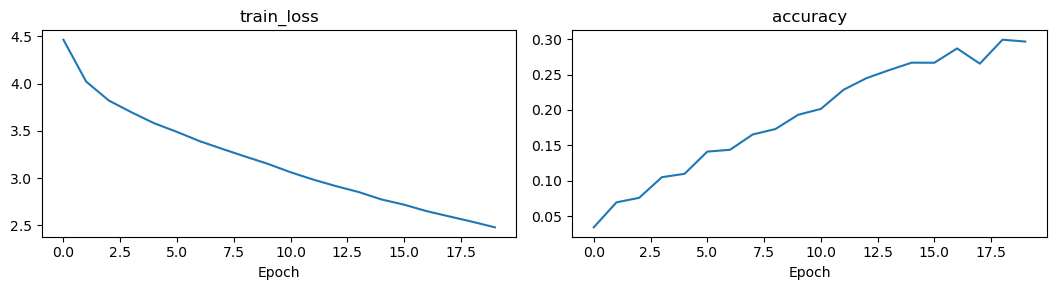

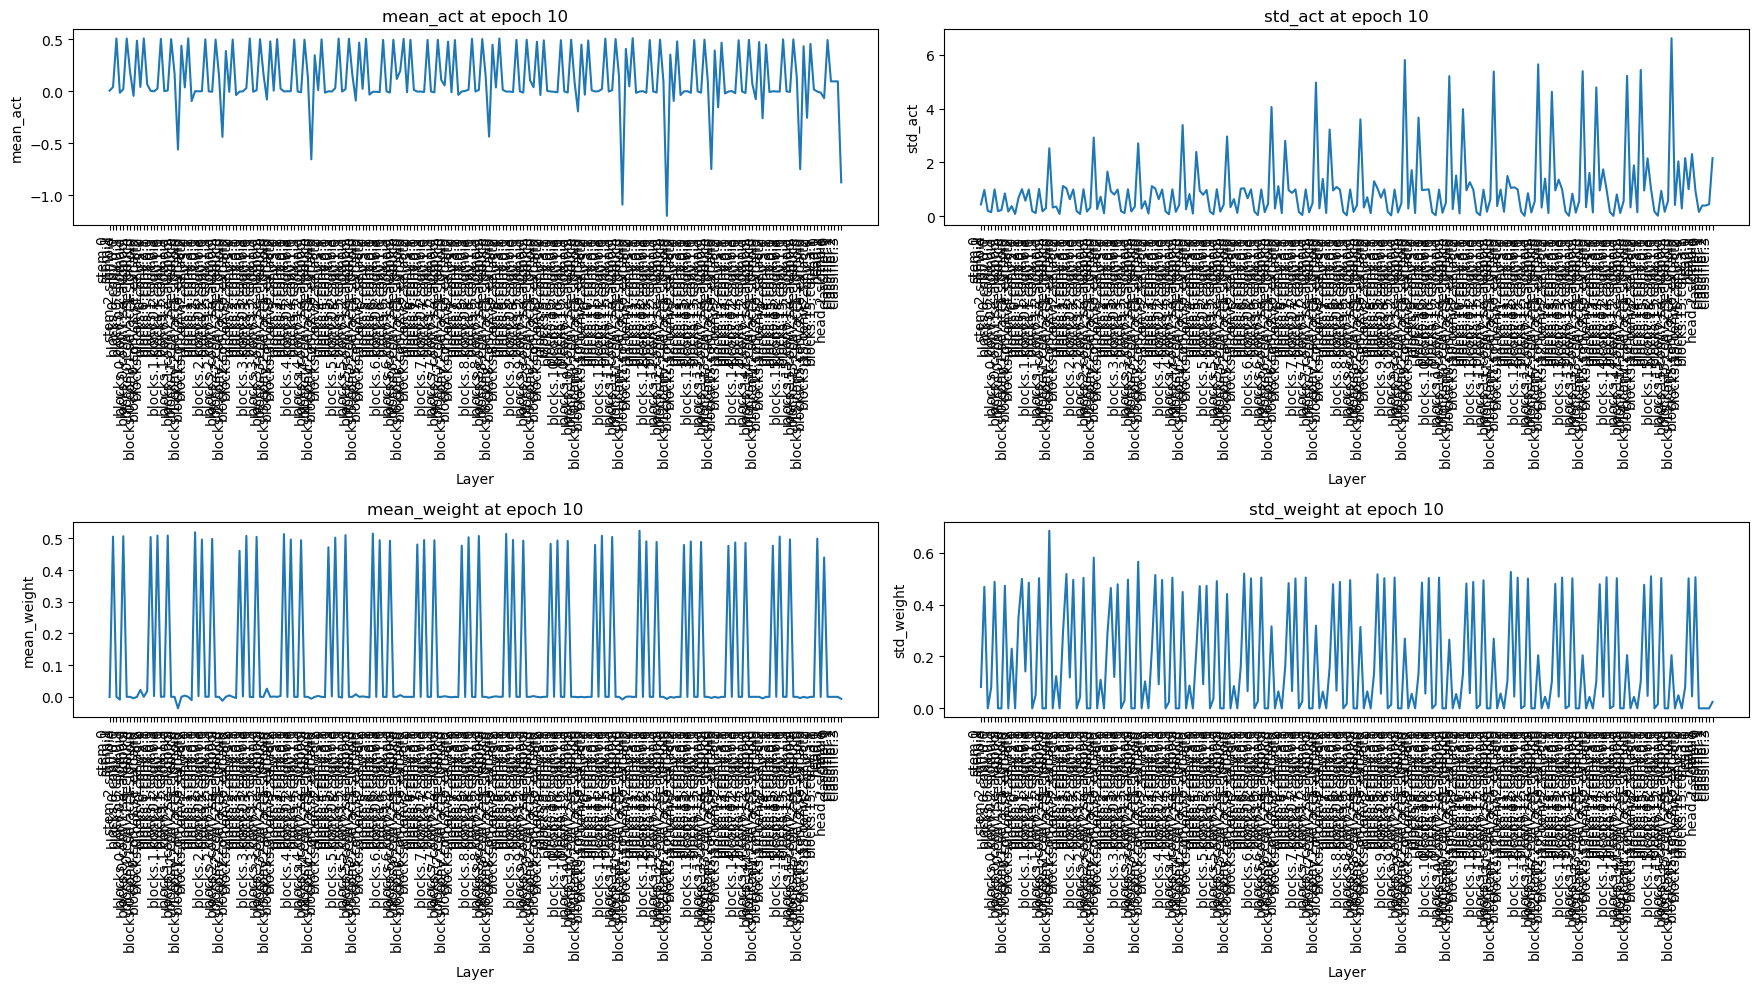

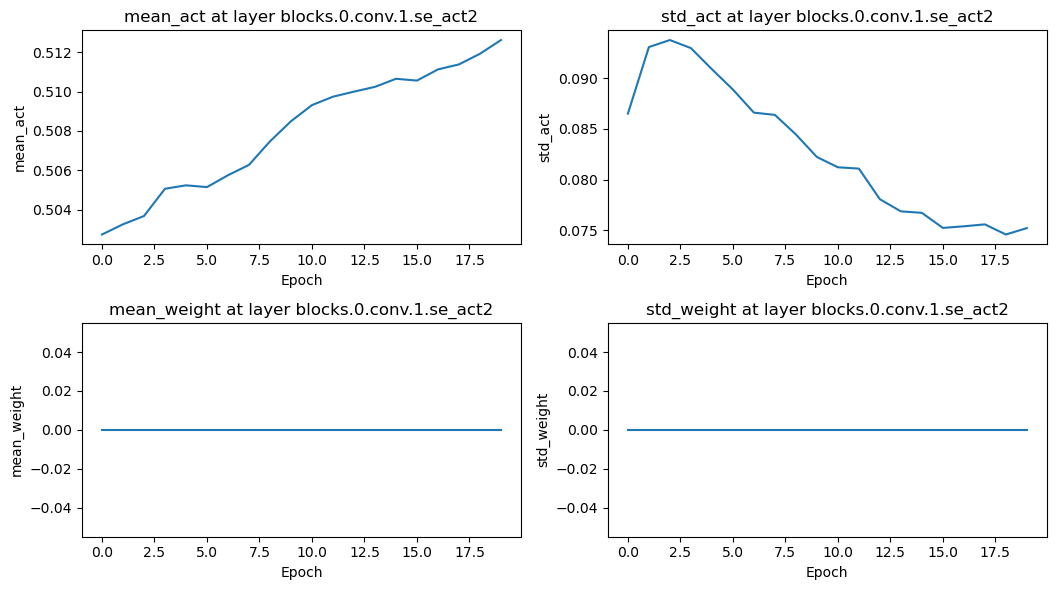

In [118]:
# Plot the training and testing metrics
plot_metrics(train_df, ["train_loss", "accuracy"], fig_size_modifier=3)
plot_epoch_signal(train_layers_df, ["mean_act", "std_act", "mean_weight", "std_weight"], 10, layers=None, fig_size_modifier=5)
plot_layer_signal(train_layers_df, ["mean_act", "std_act", "mean_weight", "std_weight"], "blocks.0.conv.1.se_act2", num_epochs=None, fig_size_modifier=3)